In [ ]:
from copy import copy
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
N = 30
q = 1
T = 5000
b = 80
D = np.sqrt(b)
L = b
G = np.sqrt(b**3)
np.random.seed(0)

alphas = [80/np.sqrt(np.sum([((4*np.pi**2)**k)*((j/2)**(2*k)) for k in range(3)])) for j in range(2*N + 1)]
alphas_4 = [4*alphas[j] for j in range(len(alphas))]
D_2m = sum(alphas_4)

In [ ]:
def join_arrs(a0, arr1, arr2):
    new_arr = np.zeros(len(arr1) + len(arr2))
    new_arr[::2] = arr1
    new_arr[1::2] = arr2
    new_arr = np.concatenate(([a0], new_arr))
    return new_arr

def solve_euler(h, q):
    t = symbols('t')
    x = Function('x')
    C1 = symbols('C1')
    C2 = symbols('C2')
    x = dsolve(- diff(x(t), t, t) + q**2*x(t) - h , x(t)).rhs
    cond1 = x.subs(t, 0) - x.subs(t, 1)
    cond2 = diff(x, t).subs(t, 0) - diff(x, t).subs(t, 1)
    solution = solve([cond1, cond2], [C1, C2])
    x = x.subs(C1, solution[C1]).subs(C2, solution[C2])
    return x

def pop_fourier_coefs(func):
    a0 =  np.trapezoid(func(np.linspace(0, 1, 100)), np.linspace(0, 1, 100))
    an = np.zeros(N)
    bn = np.zeros(N)

    for n in range(1, N+1):
        an[n-1] =  np.trapezoid(func(np.linspace(0, 1, 100)) * np.sqrt(2)*np.cos(n * 2*np.pi * np.linspace(0, 1, 100)), np.linspace(0, 1, 100))
        bn[n-1] =  np.trapezoid(func(np.linspace(0, 1, 100)) * np.sqrt(2)*np.sin(n * 2*np.pi * np.linspace(0, 1, 100)), np.linspace(0, 1, 100))

    return a0, an, bn

def fourier_series(t, a0, an, bn, N):
    return a0 + np.sum([an[n] * np.sqrt(2)*np.cos((n+1) * 2*np.pi * t) + bn[n] * np.sqrt(2)*np.sin((n+1) * 2*np.pi * t) for n in range(N)])


In [ ]:
def J_n(w):
    return 0.5 * np.sum(alpha_freq * w**2) - np.sum(sqrt_alphas * h_hat * w)

## $\psi$ = 1.5

In [ ]:
np.random.seed(0)
# Initialize arrays
w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0] = np.random.random(2*N+1)
w_wave[0] = np.random.random(2*N+1)

# Symbolic setup
t = symbols('t')
h_sp = 10*pi**2*cos(2*1.5*pi*t)
h = lambdify(t, h_sp, 'numpy')

# Solve system and get Fourier coefficients
x_sp = solve_euler(h_sp, q)
x = lambdify(t, x_sp, 'numpy')
a0, an, bn = pop_fourier_coefs(x)
h_a0, h_an, h_bn = pop_fourier_coefs(h)
x_hat = join_arrs(a0, an, bn)
h_hat = join_arrs(h_a0, h_an, h_bn)

# Precompute terms
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * ((np.arange(2*N+1) // 2)**2)
alpha_freq = alphas * freq_terms

# Define gradient and objective
def gradient(w):
    return alpha_freq * w - sqrt_alphas * h_hat

def J_n(w):
    return 0.5 * np.sum(alpha_freq * w**2) - np.sum(sqrt_alphas * h_hat * w)

# Initialize variables
eta = np.zeros(T)
eta[0] = D / np.sqrt(10*D**2*L**2 + 4*G**2)
gradient_history = np.zeros((T, 2*N+1))
dif_grads_norm = []
J_opt = J_n(x_hat / sqrt_alphas)
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []

# Main loop
for i in range(T-1):
    gradient_history[i+1] = gradient(w[i])

    grad_diff = gradient_history[i+1] - gradient_history[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))
    eta[i+1] = D / np.sqrt(10*D**2*L**2 + 4*G**2 + np.sum(dif_grads_norm))

    w_wave[i+1] = np.clip(w_wave[i] - eta[i] * gradient_history[i], -np.sqrt(alphas), np.sqrt(alphas))
    w[i+1] = np.clip(w_wave[i+1] - eta[i+1] * gradient_history[i], -np.sqrt(alphas), np.sqrt(alphas))

    current_diff = J_n(w[i]) - J_opt
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n) / np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n) / n)

In [ ]:
Regret_J_n[-1]

np.float64(101.36060713464843)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(2.0484584047605807)

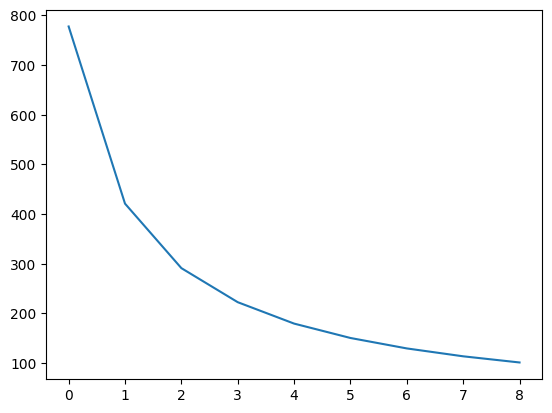

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.random.normal(0, 0.03, T)

In [ ]:
np.random.seed(0)
# Precompute constants
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
alpha_freq = alphas * freq_terms

# Initialize arrays
w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0] = np.random.random(2*N+1)
w_wave[0] = np.random.random(2*N+1)

# Tracking variables
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = np.random.normal(0, 0.03, T)

# Learning rate setup
eta = np.zeros(T)
eta[0] = D/np.sqrt(10*D**2*L**2 + 4*G**2)
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []

t = symbols('t')  # Time symbol

for i in range(T-1):
    # System dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp, 'numpy')
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp, 'numpy')

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Gradient and objective
    gradient_w[i+1] = alpha_freq * w[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w[i]**2) - np.sum(sqrt_alphas * h_hat * w[i])

    # Update learning rate
    grad_diff = gradient_w[i+1] - gradient_w[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))
    eta[i+1] = D/np.sqrt(10*D**2*L**2 + 4*G**2 + np.sum(dif_grads_norm))

    # Weight updates
    w_wave[i+1] = np.clip(w_wave[i] - eta[i] * gradient_w[i], -np.sqrt(alphas), np.sqrt(alphas))
    w[i+1] = np.clip(w_wave[i+1] - eta[i+1] * gradient_w[i], -np.sqrt(alphas), np.sqrt(alphas))

    # Regret calculation
    current_diff = J_n_current - (0.5*np.sum(alpha_freq * (x_hat/sqrt_alphas)**2) - np.sum(sqrt_alphas * h_hat * (x_hat/sqrt_alphas)))
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(545.5074307554078)

In [ ]:
Regret_J_n[-1]

np.float64(1760.2311110734495)

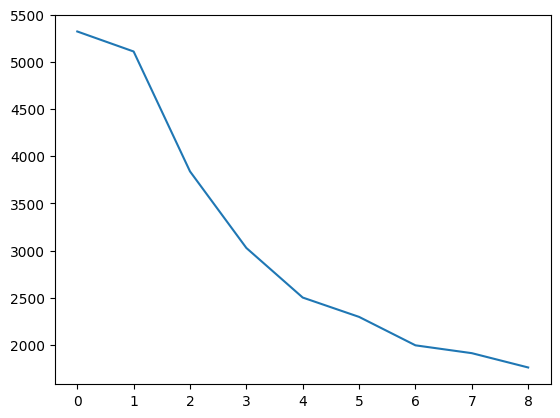

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.linspace(2, 3, T)

In [ ]:
np.random.seed(0)
# Precompute constants
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
alpha_freq = alphas * freq_terms

# Initialize arrays
w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0] = np.random.random(2*N+1)
w_wave[0] = np.random.random(2*N+1)

# Tracking variables
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = np.linspace(2, 3, T)

# Learning rate setup
eta = np.zeros(T)
eta[0] = D/np.sqrt(10*D**2*L**2 + 4*G**2)
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []

t = symbols('t')  # Time symbol

for i in range(T-1):
    # System dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp, 'numpy')
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp, 'numpy')

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Gradient and objective
    gradient_w[i+1] = alpha_freq * w[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w[i]**2) - np.sum(sqrt_alphas * h_hat * w[i])

    # Update learning rate
    grad_diff = gradient_w[i+1] - gradient_w[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))
    eta[i+1] = D/np.sqrt(10*D**2*L**2 + 4*G**2 + np.sum(dif_grads_norm))

    # Weight updates
    w_wave[i+1] = np.clip(w_wave[i] - eta[i] * gradient_w[i], -np.sqrt(alphas), np.sqrt(alphas))
    w[i+1] = np.clip(w_wave[i+1] - eta[i+1] * gradient_w[i], -np.sqrt(alphas), np.sqrt(alphas))

    # Regret calculation
    current_diff = J_n_current - (0.5*np.sum(alpha_freq * (x_hat/sqrt_alphas)**2) - np.sum(sqrt_alphas * h_hat * (x_hat/sqrt_alphas)))
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(236.62906944923463)

In [ ]:
Regret_J_n[-1]

np.float64(502.228282934797)

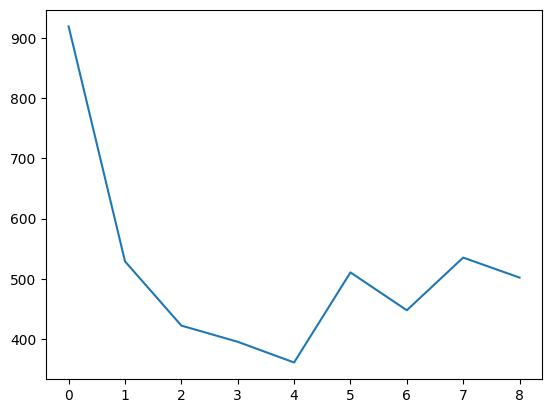

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = [0.5]*int(T/2) + [1.5]*int(T/2)

In [ ]:
# Precompute constants
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
alpha_freq = alphas * freq_terms

np.random.seed(0)

# Initialize arrays
w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0] = np.random.random(2*N+1)
w_wave[0] = np.random.random(2*N+1)

# Tracking variables
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = [0.5]*int(T/2) + [1.5]*int(T/2)

# Learning rate setup
eta = np.zeros(T)
eta[0] = D/np.sqrt(10*D**2*L**2 + 4*G**2)
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []

t = symbols('t')  # Time symbol

for i in range(T-1):
    # System dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp, 'numpy')
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp, 'numpy')

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Gradient and objective
    gradient_w[i+1] = alpha_freq * w[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w[i]**2) - np.sum(sqrt_alphas * h_hat * w[i])

    # Update learning rate
    grad_diff = gradient_w[i+1] - gradient_w[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))
    eta[i+1] = D/np.sqrt(10*D**2*L**2 + 4*G**2 + np.sum(dif_grads_norm))

    # Weight updates
    w_wave[i+1] = np.clip(w_wave[i] - eta[i] * gradient_w[i], -np.sqrt(alphas), np.sqrt(alphas))
    w[i+1] = np.clip(w_wave[i+1] - eta[i+1] * gradient_w[i], -np.sqrt(alphas), np.sqrt(alphas))

    # Regret calculation
    current_diff = J_n_current - (0.5*np.sum(alpha_freq * (x_hat/sqrt_alphas)**2) - np.sum(sqrt_alphas * h_hat * (x_hat/sqrt_alphas)))
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

np.float64(430.00537231215344)

In [ ]:
Regret_J_n[-1]

np.float64(525.0224876376947)

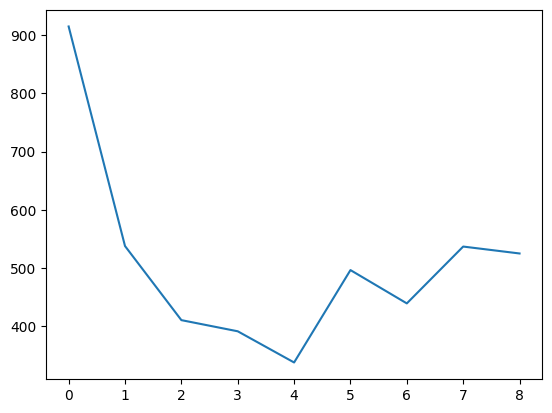

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)

In [ ]:
np.random.seed(0)
# Precompute constants
sqrt_alphas = np.sqrt(alphas)
freq_terms = q**2 + (2*np.pi)**2 * np.ceil(np.arange(2*N+1)/2)**2
alpha_freq = alphas * freq_terms

# Initialize arrays
w = np.zeros((T, 2*N+1))
w_wave = np.zeros((T, 2*N+1))
w[0] = np.random.random(2*N+1)
w_wave[0] = np.random.random(2*N+1)

# Tracking variables
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []
psi = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)

# Learning rate setup
eta = np.zeros(T)
eta[0] = D/np.sqrt(10*D**2*L**2 + 4*G**2)
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []

t = symbols('t')  # Time symbol

for i in range(T-1):
    # System dynamics
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp, 'numpy')
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp, 'numpy')

    # Fourier coefficients
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Gradient and objective
    gradient_w[i+1] = alpha_freq * w[i] - sqrt_alphas * h_hat
    J_n_current = 0.5*np.sum(alpha_freq * w[i]**2) - np.sum(sqrt_alphas * h_hat * w[i])

    # Update learning rate
    grad_diff = gradient_w[i+1] - gradient_w[i]
    dif_grads_norm.append(np.dot(grad_diff, grad_diff))
    eta[i+1] = D/np.sqrt(10*D**2*L**2 + 4*G**2 + np.sum(dif_grads_norm))

    # Weight updates
    w_wave[i+1] = np.clip(w_wave[i] - eta[i] * gradient_w[i], -np.sqrt(alphas), np.sqrt(alphas))
    w[i+1] = np.clip(w_wave[i+1] - eta[i+1] * gradient_w[i], -np.sqrt(alphas), np.sqrt(alphas))

    # Regret calculation
    current_diff = J_n_current - (0.5*np.sum(alpha_freq * (x_hat/sqrt_alphas)**2) - np.sum(sqrt_alphas * h_hat * (x_hat/sqrt_alphas)))
    Dif_J_n.append(current_diff)
    n = len(Dif_J_n)
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(n))
    Regret_J_n.append(np.sum(Dif_J_n)/n)

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

5.13020302091592

In [ ]:
Regret_J_n[-1]

np.float64(206.2508185887221)

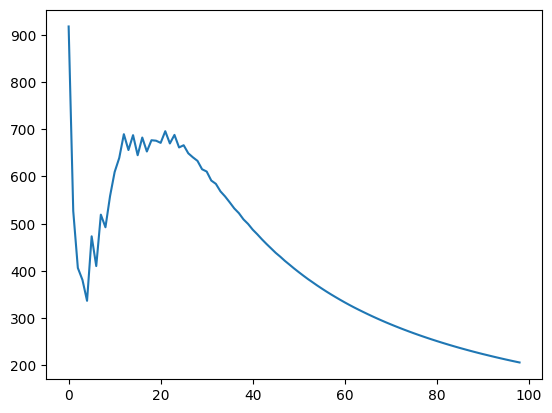

In [ ]:
plt.plot(Regret_J_n)

## Strong convexity (take another $\eta$)
eta = [2/(10*(i+1)) for i in range(T)]

## $\psi$ = 1.5

In [ ]:
# Set random seed for reproducibility
np.random.seed(0)

# Initialize main and auxiliary weight vectors
w, w_wave = np.zeros((T, 2*N+1)), np.zeros((T, 2*N+1))
w[0], w_wave[0] = np.random.random(2*N+1), np.random.random(2*N+1)

# Initialize performance tracking lists
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []

# Define symbolic function for dynamics
psi = 1.5
t = symbols('t')
h_sp = 10*pi**2*cos(2*psi*pi*t)
h = lambdify(t, h_sp)

# Solve Euler-Lagrange equation and get solution
x_sp = solve_euler(h_sp, q)
x = lambdify(t, x_sp)

# Compute Fourier coefficients
a0, an, bn = pop_fourier_coefs(x)
h_a0, h_an, h_bn = pop_fourier_coefs(h)

# Combine coefficients into arrays
x_hat = join_arrs(a0, an, bn)
h_hat = join_arrs(h_a0, h_an, h_bn)

# Define gradient components
def grad_J(w, j):
    return alphas[j]*(q**2 + (2*np.pi)**2*np.ceil(j/2)**2)*w[j] - sqrt(alphas[j])*h_hat[j]

# Full gradient computation
def gradient(w):
    return np.array([grad_J(w, j) for j in range(2*N+1)])

# Objective function
def J_n(w):
    return 0.5*(np.sum([alphas[j]*(q**2 + ((2*np.pi)**2)*np.ceil(j/2)**2)*w[j]**2 for j in range(2*N + 1)]))- np.sum([sqrt(alphas[j])*h_hat[j]*w[j] for j in range(2*N + 1)])

# Learning rate schedule
eta = [2/(80*(i+1)) for i in range(T)]
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []

# Main optimization loop
for i in range(T-1):
    # Compute current gradient
    gradient_w[i+1] = gradient(w[i])
    dif_grads_norm.append(np.linalg.norm(gradient_w[i+1] - gradient_w[i], 2)**2)

    # Update auxiliary and main weights with projection
    w_wave[i+1] = np.clip(w_wave[i] - eta[i]*gradient(w[i]), -np.sqrt(alphas), np.sqrt(alphas))
    w[i+1] = np.clip(w_wave[i+1] - eta[i+1]*gradient(w[i]), -np.sqrt(alphas), np.sqrt(alphas))

    # Track performance metrics
    Dif_J_n.append(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(len(Dif_J_n)))
    Regret_J_n.append(np.sum(Dif_J_n)/(len(Dif_J_n)))

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

7.57834325924023e-5

In [ ]:
Regret_J_n[-1]

3.36740326278151

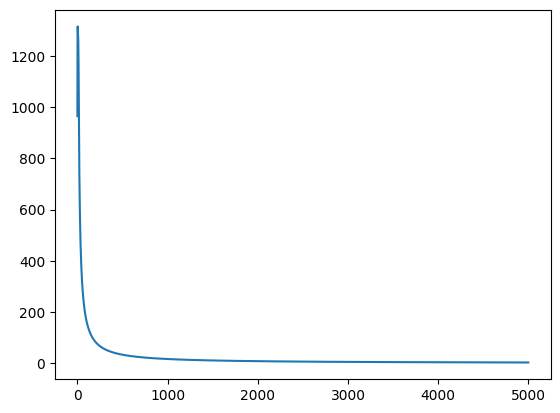

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.random.normal(0, 0.03, T)

In [ ]:
# Set random seed for reproducibility
np.random.seed(0)

# Initialize weight vectors for main and auxiliary parameters
w, w_wave = np.zeros((T, 2*N+1)), np.zeros((T, 2*N+1))
w[0], w_wave[0] = np.random.random(2*N+1), np.random.random(2*N+1)

# Initialize lists to track optimization performance
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []

# Generate psi values for dynamics
psi = np.random.normal(0, 0.03, T)

# Learning rate schedule (decreasing with iterations)
eta = [2/(80*(i+1)) for i in range(T)]
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []

# Main optimization loop
for i in range(T-1):
    # Define time-dependent dynamics symbolically
    t = symbols('t')
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)

    # Solve the system dynamics
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Compute Fourier coefficients of solution and dynamics
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)

    # Combine Fourier coefficients into arrays
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Define gradient component for j-th coordinate
    def grad_J(w, j):
        return alphas[j]*(q**2 + (2*np.pi)**2*np.ceil(j/2)**2)*w[j] - sqrt(alphas[j])*h_hat[j]

    # Compute full gradient vector
    def gradient(w):
        return np.array([grad_J(w, j) for j in range(2*N+1)])

    # Define objective function
    def J_n(w):
        return 0.5*(np.sum([alphas[j]*(q**2 + ((2*np.pi)**2)*np.ceil(j/2)**2)*w[j]**2 for j in range(2*N + 1)])) - np.sum([sqrt(alphas[j])*h_hat[j]*w[j] for j in range(2*N + 1)])

    # Store current gradient and compute difference from previous
    gradient_w[i+1] = gradient(w[i])
    dif_grads_norm.append(np.linalg.norm(gradient_w[i+1] - gradient_w[i], 2)**2)

    # Update auxiliary and main weights with projection
    w_wave[i+1] = np.clip(w_wave[i] - eta[i]*gradient(w[i]), -np.sqrt(alphas), np.sqrt(alphas))
    w[i+1] = np.clip(w_wave[i+1] - eta[i+1]*gradient(w[i]), -np.sqrt(alphas), np.sqrt(alphas))

    # Track optimization performance metrics
    Dif_J_n.append(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(len(Dif_J_n)))
    Regret_J_n.append(np.sum(Dif_J_n)/(len(Dif_J_n)))

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

146.718220169088

In [ ]:
Regret_J_n[-1]

168.853155023666

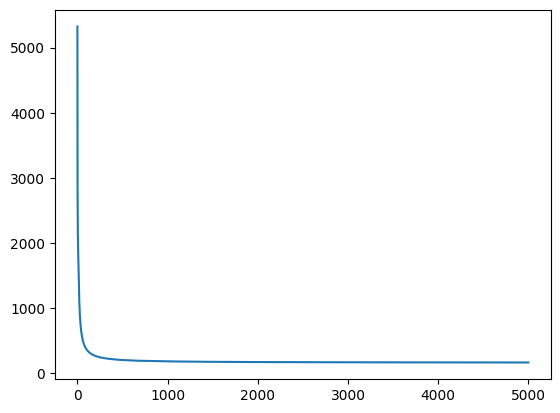

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.linspace(2, 3, T)

In [ ]:
# Set random seed for reproducibility
np.random.seed(0)

# Initialize weight vectors for main and auxiliary parameters
w, w_wave = np.zeros((T, 2*N+1)), np.zeros((T, 2*N+1))
w[0], w_wave[0] = np.random.random(2*N+1), np.random.random(2*N+1)

# Initialize lists to track optimization performance
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []

# Generate psi values for dynamics
psi = np.linspace(2, 3, T)

# Learning rate schedule (decreasing with iterations)
eta = [2/(80*(i+1)) for i in range(T)]
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []

# Main optimization loop
for i in range(T-1):
    # Define time-dependent dynamics symbolically
    t = symbols('t')
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)

    # Solve the system dynamics
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Compute Fourier coefficients of solution and dynamics
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)

    # Combine Fourier coefficients into arrays
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Define gradient component for j-th coordinate
    def grad_J(w, j):
        return alphas[j]*(q**2 + (2*np.pi)**2*np.ceil(j/2)**2)*w[j] - sqrt(alphas[j])*h_hat[j]

    # Compute full gradient vector
    def gradient(w):
        return np.array([grad_J(w, j) for j in range(2*N+1)])

    # Define objective function
    def J_n(w):
        return 0.5*(np.sum([alphas[j]*(q**2 + ((2*np.pi)**2)*np.ceil(j/2)**2)*w[j]**2 for j in range(2*N + 1)])) - np.sum([sqrt(alphas[j])*h_hat[j]*w[j] for j in range(2*N + 1)])

    # Store current gradient and compute difference from previous
    gradient_w[i+1] = gradient(w[i])
    dif_grads_norm.append(np.linalg.norm(gradient_w[i+1] - gradient_w[i], 2)**2)

    # Update auxiliary and main weights with projection
    w_wave[i+1] = np.clip(w_wave[i] - eta[i]*gradient(w[i]), -np.sqrt(alphas), np.sqrt(alphas))
    w[i+1] = np.clip(w_wave[i+1] - eta[i+1]*gradient(w[i]), -np.sqrt(alphas), np.sqrt(alphas))

    # Track optimization performance metrics
    Dif_J_n.append(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(len(Dif_J_n)))
    Regret_J_n.append(np.sum(Dif_J_n)/(len(Dif_J_n)))

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

6.13803687651789

In [ ]:
Regret_J_n[-1]

11.5141462882255

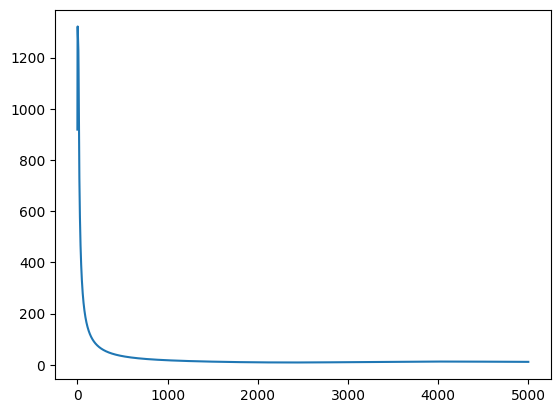

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = [0.5]*int(T/2) + [1.5]*int(T/2)

In [ ]:
# Set random seed for reproducibility
np.random.seed(0)

# Initialize weight vectors for main and auxiliary parameters
w, w_wave = np.zeros((T, 2*N+1)), np.zeros((T, 2*N+1))
w[0], w_wave[0] = np.random.random(2*N+1), np.random.random(2*N+1)

# Initialize lists to track optimization performance
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []

# Generate psi values for dynamics
psi = [0.5]*int(T/2) + [1.5]*int(T/2)

# Learning rate schedule (decreasing with iterations)
eta = [2/(80*(i+1)) for i in range(T)]
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []

# Main optimization loop
for i in range(T-1):
    # Define time-dependent dynamics symbolically
    t = symbols('t')
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)

    # Solve the system dynamics
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Compute Fourier coefficients of solution and dynamics
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)

    # Combine Fourier coefficients into arrays
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Define gradient component for j-th coordinate
    def grad_J(w, j):
        return alphas[j]*(q**2 + (2*np.pi)**2*np.ceil(j/2)**2)*w[j] - sqrt(alphas[j])*h_hat[j]

    # Compute full gradient vector
    def gradient(w):
        return np.array([grad_J(w, j) for j in range(2*N+1)])

    # Define objective function
    def J_n(w):
        return 0.5*(np.sum([alphas[j]*(q**2 + ((2*np.pi)**2)*np.ceil(j/2)**2)*w[j]**2 for j in range(2*N + 1)])) - np.sum([sqrt(alphas[j])*h_hat[j]*w[j] for j in range(2*N + 1)])

    # Store current gradient and compute difference from previous
    gradient_w[i+1] = gradient(w[i])
    dif_grads_norm.append(np.linalg.norm(gradient_w[i+1] - gradient_w[i], 2)**2)

    # Update auxiliary and main weights with projection
    w_wave[i+1] = np.clip(w_wave[i] - eta[i]*gradient(w[i]), -np.sqrt(alphas), np.sqrt(alphas))
    w[i+1] = np.clip(w_wave[i+1] - eta[i+1]*gradient(w[i]), -np.sqrt(alphas), np.sqrt(alphas))

    # Track optimization performance metrics
    Dif_J_n.append(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(len(Dif_J_n)))
    Regret_J_n.append(np.sum(Dif_J_n)/(len(Dif_J_n)))

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

6.86222991140434

In [ ]:
Regret_J_n[-1]

19.6953958861830

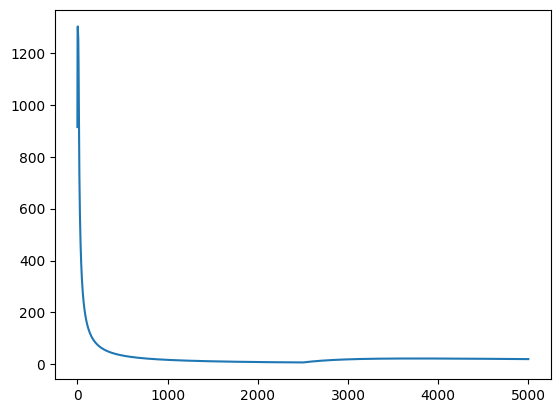

In [ ]:
plt.plot(Regret_J_n)

## $\psi$ = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)

In [ ]:
# Set random seed for reproducibility
np.random.seed(0)

# Initialize weight vectors for main and auxiliary parameters
w, w_wave = np.zeros((T, 2*N+1)), np.zeros((T, 2*N+1))
w[0], w_wave[0] = np.random.random(2*N+1), np.random.random(2*N+1)

# Initialize lists to track optimization performance
Regret_J_n, Regret_J_n_sqrt = [], []
Dif_J_n = []
grads = []

# Generate psi values for dynamics
psi = np.linspace(2, 3, T) + np.random.normal(0, 0.03, T)

# Learning rate schedule (decreasing with iterations)
eta = [2/(80*(i+1)) for i in range(T)]
gradient_w = np.zeros((T, 2*N+1))
dif_grads_norm = []

# Main optimization loop
for i in range(T-1):
    # Define time-dependent dynamics symbolically
    t = symbols('t')
    h_sp = 10*pi**2*cos(2*psi[i]*pi*t)
    h = lambdify(t, h_sp)

    # Solve the system dynamics
    x_sp = solve_euler(h_sp, q)
    x = lambdify(t, x_sp)

    # Compute Fourier coefficients of solution and dynamics
    a0, an, bn = pop_fourier_coefs(x)
    h_a0, h_an, h_bn = pop_fourier_coefs(h)

    # Combine Fourier coefficients into arrays
    x_hat = join_arrs(a0, an, bn)
    h_hat = join_arrs(h_a0, h_an, h_bn)

    # Define gradient component for j-th coordinate
    def grad_J(w, j):
        return alphas[j]*(q**2 + (2*np.pi)**2*np.ceil(j/2)**2)*w[j] - sqrt(alphas[j])*h_hat[j]

    # Compute full gradient vector
    def gradient(w):
        return np.array([grad_J(w, j) for j in range(2*N+1)])

    # Define objective function
    def J_n(w):
        return 0.5*(np.sum([alphas[j]*(q**2 + ((2*np.pi)**2)*np.ceil(j/2)**2)*w[j]**2 for j in range(2*N + 1)])) - np.sum([sqrt(alphas[j])*h_hat[j]*w[j] for j in range(2*N + 1)])

    # Store current gradient and compute difference from previous
    gradient_w[i+1] = gradient(w[i])
    dif_grads_norm.append(np.linalg.norm(gradient_w[i+1] - gradient_w[i], 2)**2)

    # Update auxiliary and main weights with projection
    w_wave[i+1] = np.clip(w_wave[i] - eta[i]*gradient(w[i]), -np.sqrt(alphas), np.sqrt(alphas))
    w[i+1] = np.clip(w_wave[i+1] - eta[i+1]*gradient(w[i]), -np.sqrt(alphas), np.sqrt(alphas))

    # Track optimization performance metrics
    Dif_J_n.append(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))
    Regret_J_n_sqrt.append(np.sum(Dif_J_n)/np.sqrt(len(Dif_J_n)))
    Regret_J_n.append(np.sum(Dif_J_n)/(len(Dif_J_n)))

In [ ]:
np.abs(J_n(w[i]) - J_n(x_hat/np.sqrt(alphas)))

3.38607085562185

In [ ]:
Regret_J_n[-1]

11.7753038838482

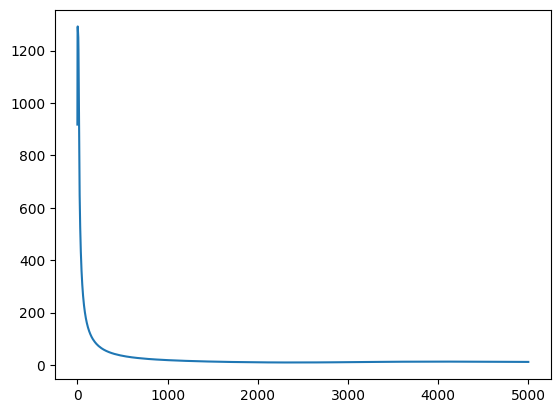

In [ ]:
plt.plot(Regret_J_n)